In [ ]:
#Created on 17 June 2022
#Last Modified on 19 July 2022
#FYP for Mr. Tian Kai Wen TP051580
#Computer Science (Intelligent system)
#Asia Pacific University
#Training

#The code here is to train the data. 
#The stucture of neural network would be defined and dataloader would be used.
#The code here would also plot graph for accuracy and losses for training and validation

In [ ]:
#Install and import libraries
!pip3 install face_recognition
import pandas as pd
import numpy as np
import math
import torch
import torchvision
import os
import cv2
import matplotlib.pyplot as plt
import face_recognition
import time
import sys
import seaborn as sn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn
from torchvision import models
from google.colab import drive
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Dataset class to load video for dataloader
class videoDataset(Dataset):
    def __init__(self,videoNames,labels,sequenceLength = 60,transform = None):
        self.videoNames = videoNames
        self.labels = labels
        self.transform = transform
        self.count = sequenceLength
    def __len__(self):
        return len(self.videoNames)
    def __getitem__(self,idx):
        videoPath = self.videoNames[idx]
        frames = []
        tempVideo = videoPath.split('/')[-1]
        label=self.labels[tempVideo]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frameExtract(videoPath)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames,label
    def frameExtract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image

In [ ]:
#The architecture of the model
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.wide_resnet50_2(weights='Wide_ResNet50_2_Weights.DEFAULT')
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
#To begin the training process
def train(epoch, numEpochs, dataLoader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(dataLoader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculateAccuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    numEpochs,
                    i,
                    len(dataLoader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg
#To test the model
def test(epoch,model, dataLoader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataLoader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculateAccuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(dataLoader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

#To calculate the average
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#To calculate accuracy 
def calculateAccuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
#To generate confusion matrix
def confusionMatrix(yTrue, yPred):
    cm = confusion_matrix(yTrue, yPred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    dfCm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(dfCm, annot=True, annot_kws={"size": 16})
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

#To plot training and validation loss
def loss(trainLossAvg,testLossAvg,numEpochs):
  lossTrain = trainLossAvg
  lossVal = testLossAvg
  print(numEpochs)
  epochs = range(1,numEpochs+1)
  plt.plot(epochs, lossTrain, 'g', label='Training loss')
  plt.plot(epochs, lossVal, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

#To plot accuracy
def accuracy(trainAccuracy,testAccuracy,numEpochs):
  lossTrain = trainAccuracy
  lossVal = testAccuracy
  epochs = range(1,numEpochs+1)
  plt.plot(epochs, lossTrain, 'g', label='Training accuracy')
  plt.plot(epochs, lossVal, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
dfTrain = pd.read_json('/content/drive/MyDrive/Deepfake dataset/dataset/metadata.json').transpose()
dfTrain.describe()

,label,split,original
count,622,622,300
unique,2,1,202
top,REAL,train,meawmsgiti.mp4
freq,322,622,6


In [ ]:
print(dfTrain)

               label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4
acifjvzvpm.mp4  FAKE  train  kbvibjhfzo.mp4
...              ...    ...             ...
lmccjyztbs.mp4  REAL  train             NaN
gheozjcomi.mp4  REAL  train             NaN
evkmmqbdgq.mp4  REAL  train             NaN
hiixalzbpk.mp4  REAL  train             NaN
oklqybrmhv.mp4  REAL  train             NaN

[622 rows x 3 columns]


In [ ]:
dfTrain = dfTrain.sample(frac=1)
print(dfTrain)

               label  split        original
bkwxhglwct.mp4  FAKE  train  gjypopglvi.mp4
dptrzdvwpg.mp4  FAKE  train  iiomvouemm.mp4
drsakwyvqv.mp4  FAKE  train  jomvcqqars.mp4
glshmsgdyw.mp4  REAL  train             NaN
dqswpjoepo.mp4  FAKE  train  kydlpqfrvv.mp4
...              ...    ...             ...
dozyddhild.mp4  FAKE  train  ngdswpaqnt.mp4
hkvfyeacje.mp4  REAL  train             NaN
pmsccgvvut.mp4  REAL  train             NaN
bqnymlsayl.mp4  FAKE  train  xagsvjctmp.mp4
lynaeydofd.mp4  REAL  train             NaN

[622 rows x 3 columns]


In [ ]:
df=dfTrain.groupby("label")
df.first()


,split,original
label,,
FAKE,train,gjypopglvi.mp4
REAL,train,None


In [ ]:
realData=(df.get_group('REAL'))
fakeData=(df.get_group('FAKE'))

In [ ]:
#To count (80% training data)
print(len(realData))
print(len(fakeData))
totalData=len(realData)+len(fakeData)
amountTrainData=int((math.ceil(totalData*0.8))/2)
print(amountTrainData)

322
300
249


In [ ]:
#To split train and test data, train data is split by 50% for real and fake data
trainData=realData[:amountTrainData]+fakeData[:amountTrainData]
testData=realData[amountTrainData:]+fakeData[amountTrainData:]
print(len(trainData))

498


In [ ]:
trainList=[]
validList=[]
for i in trainData.index:
  trainList.append('/content/drive/My Drive/Deepfake dataset/dataset/'+i)
  print('/content/drive/My Drive/Deepfake dataset/dataset/'+i)

for i in testData.index:
  validList.append('/content/drive/My Drive/Deepfake dataset/dataset/'+i)

/content/drive/My Drive/Deepfake dataset/dataset/aagfhgtpmv.mp4
/content/drive/My Drive/Deepfake dataset/dataset/aamjfukxwp.mp4
/content/drive/My Drive/Deepfake dataset/dataset/aapnvogymq.mp4
/content/drive/My Drive/Deepfake dataset/dataset/abarnvbtwb.mp4
/content/drive/My Drive/Deepfake dataset/dataset/abqwwspghj.mp4
/content/drive/My Drive/Deepfake dataset/dataset/acifjvzvpm.mp4
/content/drive/My Drive/Deepfake dataset/dataset/acqfdwsrhi.mp4
/content/drive/My Drive/Deepfake dataset/dataset/acxnxvbsxk.mp4
/content/drive/My Drive/Deepfake dataset/dataset/acxwigylke.mp4
/content/drive/My Drive/Deepfake dataset/dataset/aczrgyricp.mp4
/content/drive/My Drive/Deepfake dataset/dataset/adohikbdaz.mp4
/content/drive/My Drive/Deepfake dataset/dataset/aelfnikyqj.mp4
/content/drive/My Drive/Deepfake dataset/dataset/aelzhcnwgf.mp4
/content/drive/My Drive/Deepfake dataset/dataset/aeolxtsnfc.mp4
/content/drive/My Drive/Deepfake dataset/dataset/aettqgevhz.mp4
/content/drive/My Drive/Deepfake dataset

In [ ]:
dataDict=dict()
for i, j in dfTrain.iterrows():
  if(j['label']=="REAL"):
    dataDict[i]="REAL"

  elif(j['label']=="FAKE"):
    dataDict[i] ="FAKE"

In [ ]:
size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
                                 transforms.ToPILImage(),
                                 transforms.Resize((size,size)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean,std)])

#Load train and validation data
trainData = videoDataset(trainList,dataDict,sequenceLength = 10,transform = transform)
valData = videoDataset(validList,dataDict,sequenceLength = 10,transform = transform)
trainLoader = DataLoader(trainData,batch_size = 4,shuffle = True,num_workers = 2)
validLoader = DataLoader(valData,batch_size = 4,shuffle = True,num_workers = 2)

In [ ]:
#Initialize model
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,10,3,112,112))).type(torch.cuda.FloatTensor))


[Epoch 1/6] [Batch 124 / 125] [Loss: 0.683698, Acc: 57.63%]Testing
[Batch 30 / 31]  [Loss: 0.655038, Acc: 68.55%]
Accuracy 68.54838709677419
[Epoch 2/6] [Batch 124 / 125] [Loss: 0.634815, Acc: 67.47%]Testing
[Batch 30 / 31]  [Loss: 0.539734, Acc: 78.23%]
Accuracy 78.2258064516129
[Epoch 3/6] [Batch 124 / 125] [Loss: 0.517632, Acc: 79.92%]Testing
[Batch 30 / 31]  [Loss: 0.372846, Acc: 84.68%]
Accuracy 84.6774193548387
[Epoch 4/6] [Batch 124 / 125] [Loss: 0.427063, Acc: 84.14%]Testing
[Batch 30 / 31]  [Loss: 0.332261, Acc: 81.45%]
Accuracy 81.45161290322581
[Epoch 5/6] [Batch 124 / 125] [Loss: 0.362941, Acc: 87.35%]Testing
[Batch 30 / 31]  [Loss: 0.273231, Acc: 87.90%]
Accuracy 87.90322580645162
[Epoch 6/6] [Batch 124 / 125] [Loss: 0.396279, Acc: 85.74%]Testing
[Batch 30 / 31]  [Loss: 0.278033, Acc: 86.29%]
Accuracy 86.29032258064517
6


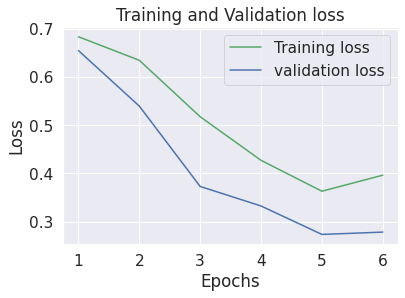

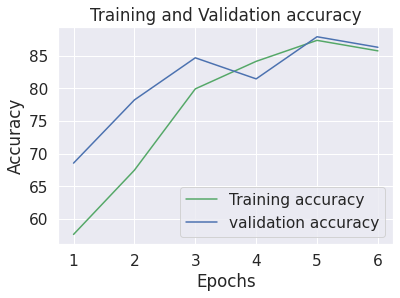

True positive =  42
False positive =  9
False negative =  8
True negative =  65




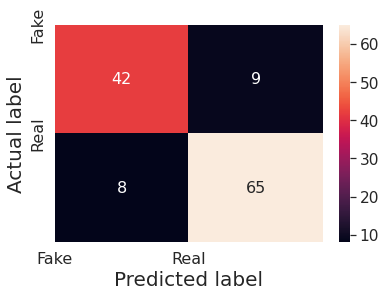

Calculated Accuracy 86.29032258064517


In [ ]:
#Training
lr = 1e-5
numEpochs = 6

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()
trainLossAvg =[]
trainAccuracy = []
testLossAvg = []
testAccuracy = []
for epoch in range(1,numEpochs+1):
    l, acc = train(epoch,numEpochs,trainLoader,model,criterion,optimizer)
    trainLossAvg.append(l)
    trainAccuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,validLoader,criterion)
    testLossAvg.append(tl)
    testAccuracy.append(t_acc)
loss(trainLossAvg,testLossAvg,len(trainLossAvg))
accuracy(trainAccuracy,testAccuracy,len(trainAccuracy))
confusionMatrix(true,pred)